## Text Classification

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
# Change the path to where you have uploaded the files.

* Text Classification is an automated process of classification of text into pre-defined categories. We can classify emails into spam or non-spam, news articles into different categories like Politics, Technology, Sports, etc.

#### Loading required libraries

In [2]:
import pandas as pd
import numpy as np
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes, svm
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

/Users/ankitjain/opt/anaconda3/lib/python3.7/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


#### SMS Spam Collection Dataset

__Context:__

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,572 messages, tagged as "ham" (legitimate) or "spam".

__Content:__

The file 'SMSSpamCollection.csv' contains one message per line. Each line is composed of two columns: column1 contains the label (ham or spam) and column2 contains the raw text.

#### Reading the dataset

In [3]:
Corpus = pd.read_csv("./SMSSpamCollection.csv",delimiter="\t",encoding='utf-8',header=None)

#### Check the number of rows and columns

In [4]:
Corpus.shape

(5572, 2)

In [5]:
pd.set_option('display.max_colwidth', 200)

#### Display top 5 rows

In [6]:
Corpus.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


#### Change column names to 'type' and 'text' from 0 and 1 respectively

In [7]:
Corpus.columns = ['type','text'] # Changing Column names

#### Display top 5 rows

In [8]:
Corpus.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


#### Check the counts in 'ham' and 'spam'

In [9]:
Corpus['type'].value_counts()

ham     4825
spam     747
Name: type, dtype: int64

#### Check the distribution of the two classes

In [10]:
Corpus['type'].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: type, dtype: float64

#### Checking for Null values

In [11]:
Corpus.isnull().sum()

type    0
text    0
dtype: int64

#### Observation: There are no Null values in the dataset

### Text Pre-processing

In [12]:
# Step - a: Remove blank rows if any
# Corpus['text'].dropna(inplace=True) 

# Step - b: Change all the text to lower case. This is required as python interprets 'data' and 'DATA' differently
Corpus['text'] = [token.lower() for token in Corpus['text']]

# Step - c: Tokenization and Remove Stop words, Non-Numeric and perfom Word Lemmatization.

stop_words = list(STOP_WORDS)
for index, entry in enumerate(Corpus['text']):
    tokens = [token.lemma_ for token in nlp(entry) if str(token) not in stop_words and token.is_alpha == True]
    clean_text = " ".join(tokens)
    Corpus.loc[index,'clean_text'] = clean_text

#### Display top 5 rows after Text Pre-processing

In [13]:
Corpus.head()

,type,text,clean_text
0,ham,"go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...",jurong point crazy available bugis n great world la e buffet cine get amore wat
1,ham,ok lar... joking wif u oni...,ok lar joke wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's,free entry wkly comp win fa cup final tkts text fa receive entry txt apply
3,ham,u dun say so early hor... u c already then say...,u dun early hor u c
4,ham,"nah i don't think he goes to usf, he lives around here though",nah think go usf live


In [14]:
# remove short words (length < 2)
Corpus['meaningful_text'] = Corpus['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))

In [15]:
Corpus.head()

,type,text,clean_text,meaningful_text
0,ham,"go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...",jurong point crazy available bugis n great world la e buffet cine get amore wat,jurong point crazy available bugis great world la buffet cine get amore wat
1,ham,ok lar... joking wif u oni...,ok lar joke wif u oni,ok lar joke wif oni
2,spam,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c's apply 08452810075over18's,free entry wkly comp win fa cup final tkts text fa receive entry txt apply,free entry wkly comp win fa cup final tkts text fa receive entry txt apply
3,ham,u dun say so early hor... u c already then say...,u dun early hor u c,dun early hor
4,ham,"nah i don't think he goes to usf, he lives around here though",nah think go usf live,nah think go usf live


In [16]:
Corpus.dtypes

type               object
text               object
clean_text         object
meaningful_text    object
dtype: object

In [17]:
# Convert the 'type' column to appropriate datatype
Corpus['type']=Corpus['type'].astype("category")

In [18]:
Corpus.dtypes

type               category
text                 object
clean_text           object
meaningful_text      object
dtype: object

### Visualizing most frequent words using WordCloud

In [19]:
# !pip install wordcloud
# !conda install -c conda-forge wordcloud=1.6.0

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [21]:
spam_messages = Corpus[Corpus["type"] == "spam"]["meaningful_text"]
ham_messages = Corpus[Corpus["type"] == "ham"]["meaningful_text"]

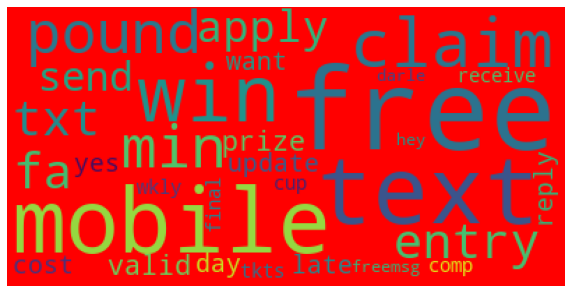

In [22]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="red").generate(str(spam_messages))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

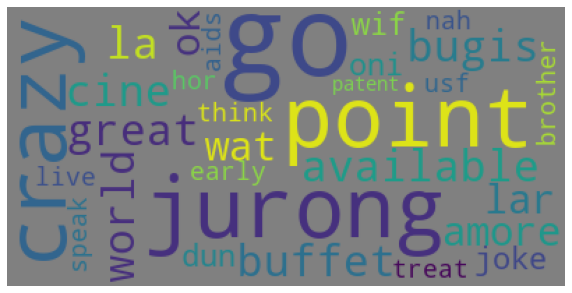

In [23]:
wordcloud = WordCloud(max_font_size=80,max_words=30, background_color="gray").generate(str(ham_messages))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Perform the train test split on the data and then build the model

In [24]:
train_X, test_X, train_y, test_y = train_test_split(Corpus['meaningful_text'],Corpus['type'],stratify = Corpus['type'],test_size=0.3,random_state=123)


In [25]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(3900,)
(1672,)
(3900,)
(1672,)


In [26]:
train_X.head()

4897                                                                           half year miss
376                                                                                    happen
2896                                                                     go ganesh dress shop
3472    heart love mind wisdom eye dream amp life frnd alwys touch good night amp sweet dream
2264           hear rude chat private line cum wan pic gettin shag text pix send stop sam xxx
Name: meaningful_text, dtype: object

In [27]:
train_y.head()

4897     ham
376      ham
2896     ham
3472     ham
2264    spam
Name: type, dtype: category
Categories (2, object): ['ham', 'spam']

In [28]:
test_X.head()

4620                                                                   sorry later meeting
573                                                                              open door
1591        somewhr surely god decide perfect time meet dat person till den enjoy ur crush
1236    opinion jada kusruthi lovable silent spl character mature stylish simple pls reply
4819                                                                              ur paper
Name: meaningful_text, dtype: object

In [29]:
test_y.head()

4620    ham
573     ham
1591    ham
1236    ham
4819    ham
Name: type, dtype: category
Categories (2, object): ['ham', 'spam']

### Calculate TF-TDF
####  Term Frequency: This summarizes how often a given word appears within a document
#### Inverse Document Frequency: This down scales words that appear a lot across documents

In [30]:
# Extending stop words list
stop_words = list(stop_words) + ['aa','aah','da','lar','ok']

Tfidf_vect = TfidfVectorizer(stop_words=stop_words,max_df=0.8)
# Tfidf_vect.fit(Corpus['meaningful_text'])

Tfidf_vect.fit(train_X)

train_X_Tfidf = Tfidf_vect.transform(train_X)
test_X_Tfidf = Tfidf_vect.transform(test_X)

In [31]:
print(train_X_Tfidf.shape)

(3900, 5067)


In [32]:
print(train_X_Tfidf[0])

  (0, 5018)	0.563108225545616
  (0, 2736)	0.5346386025312875
  (0, 1842)	0.6301354544907463


In [33]:
# Coverting to dense matrix and putting in a dataframe to view the Tfidf matrix
Dense_mat = train_X_Tfidf.todense()
Tfidf_Mat = pd.DataFrame(Dense_mat, columns=Tfidf_vect.get_feature_names())
Tfidf_Mat.head()

,aaooooright,aathi,ab,abbey,abeg,abel,aberdeen,abi,ability,abiola,...,zebra,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
for col in Tfidf_Mat.columns:
    print(col)

aaooooright
aathi
ab
abbey
abeg
abel
aberdeen
abi
ability
abiola
abj
able
abnormally
aboutas
absolutly
abstract
abt
abta
aburo
abuse
abuser
ac
academic
acc
accent
accenture
accept
access
accessible
accidant
accident
accidentally
accommodation
accommodationvoucher
accomodate
accomodation
accordingly
account
accounts
accumulation
achan
ache
achieve
acnt
act
action
activate
active
activity
actor
actual
actually
ad
adam
add
addamsfa
addict
addie
address
adewale
adi
adjustable
admin
admirer
admission
admit
adore
adrian
adult
advance
adventure
advice
advise
affair
affection
affectionate
affidavit
afghanistan
afraid
african
aft
afternon
afternoon
aftr
ag
agalla
age
agency
agidhane
ago
agree
ah
aha
ahead
ahhh
ahhhh
ahmad
ahold
aid
aids
aig
aight
air
airport
aiya
aiyah
aiyar
aiyo
ajith
ak
aka
al
alaipayuthe
albi
album
alcohol
aldrine
alert
aletter
alex
alfie
algarve
algebra
ali
alibi
alive
allah
allalo
allday
alle
allo
allow
alright
alrite
alwa
alwys
amanda
amazing
ambitious
ambrith
american
am

#### Use the ML Algorithms to Predict the label

#### Implementing Naive Bayes

In [35]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(train_X_Tfidf,train_y)

# predict the labels on train dataset
pred_train = Naive.predict(train_X_Tfidf)

# predict the labels on validation dataset
pred_test = Naive.predict(test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score on Train set -> ", accuracy_score(train_y, pred_train)*100)
print("Naive Bayes Accuracy Score on Validation set -> ", accuracy_score(test_y, pred_test)*100)


rec = recall_score(test_y, pred_test, pos_label='spam')

prec = precision_score(test_y, pred_test, pos_label='spam')

print("Recall Score on Validation set:", rec)

print("Precision Score on Validation set:", prec)

Naive Bayes Accuracy Score on Train set ->  97.07692307692307
Naive Bayes Accuracy Score on Validation set ->  96.5909090909091
Recall Score on Validation set: 0.7455357142857143
Precision Score on Validation set: 1.0


#### Implementing SVM

In [36]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(kernel='linear')
SVM.fit(train_X_Tfidf,train_y)

# predict the labels on train dataset
pred_train1 = SVM.predict(train_X_Tfidf)

# predict the labels on validation dataset
pred_test1 = SVM.predict(test_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score on Train set -> ", accuracy_score(train_y, pred_train1)*100)
print("SVM Accuracy Score on Validation set -> ",accuracy_score(test_y, pred_test1)*100)

rec1 = recall_score(test_y, pred_test1, pos_label='spam')

prec1 = precision_score(test_y, pred_test1, pos_label='spam')

print("Recall Score on Validation set:", rec1)

print("Precision Score on Validation set:", prec1)

SVM Accuracy Score on Train set ->  99.2051282051282
SVM Accuracy Score on Validation set ->  98.20574162679426
Recall Score on Validation set: 0.8883928571428571
Precision Score on Validation set: 0.9754901960784313


__Observation__: 

    Recall is the performance metric in this case. 
    Based on the Recall score, SVM performed better than Naive Bayes